## Version

*   Test on Celeb-A (10000 Train 1000 Test based on the first 11000 images of img_align_celeba)










In [ ]:
version = "CelebA"
filename_for_download_as_pdf = "COMASure_CelebA.ipynb" # Change this to the current notebook name
task_count = 10000

In [ ]:
# Choose a dataset

dataset_name = 'Celeb-A' #@param ["DIV2K","Celeb-A"] {allow-input: true}
downscaling_factor = 4 # 1,2,3,4,8 where 1 means use original img as LR
downscaling_method = 'Bicubic' #@param ["Bicubic","Subsample"] {allow-input: true}
if dataset_name == 'DIV2K':
  img_name_list = ["{}".format(("000"+str(i+1))[-4:]) for i in range(task_count)]
  img_name_list_test = ["{}".format(("000"+str(i+1))[-4:]) for i in range(task_count,900,1)]
  img_type = "png"
elif dataset_name == 'Celeb-A':
  img_name_list = ["{}".format(("00000"+str(i+1))[-6:]) for i in range(task_count)]
  img_name_list_test = ["{}".format(("00000"+str(i+1))[-6:]) for i in range(task_count,11000,1)]
  img_type = "jpg"

img_name_list_start, img_name_list_end = img_name_list[0], img_name_list[-1]
img_name_list_test_start, img_name_list_test_end = img_name_list_test[0], img_name_list_test[-1]

upsample_scale = 5 # This is to check how well SR to an arbitrary scale can be

## Import

In [ ]:
%%capture
pip install pytorch_msssim

In [ ]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torchvision
torch.set_printoptions(precision=10)

import math
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from pytorch_msssim import ssim as ssim_sys, ms_ssim as ms_ssim_sys, SSIM, MS_SSIM
import pandas as pd
import random 
import copy
from PIL import Image
import matplotlib.pyplot as plt
import pprint
import argparse
from google.colab import files

font = {'family' : 'normal',
      'weight' : 'bold',
      'size'  : 8}

plt.rc('font', **font)
plt.style.use('seaborn-deep')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Import modules

import sys
sys.path.append('/content/gdrive/MyDrive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Finalized Codes/COMASure')
from util import *
from sine_layer import *
from network import *
from fourier_transformation import *
from model import *
from meta import *

## Dataset

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
to_image = torchvision.transforms.ToPILImage()

In [ ]:
tasks = chunks(img_name_list)

In [ ]:
%%capture
# '''A much faster way to read files from colab (using zip and unzip)'''

# Train set
if dataset_name == "DIV2K":
  if downscaling_factor != 1:
    LR_dir = "/content/gdrive/My Drive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Datasets/DIV2K/DIV2K_train_LR_bicubic_X{}.zip".format(downscaling_factor)
    !unzip "$LR_dir" -d "/content"
  if img_name_list_start == "0001" and img_name_list_end == "0800":
    HR_dir = "/content/gdrive/My Drive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Datasets/DIV2K/DIV2K_train_HR.zip"
  else:
    HR_dir = "/content/gdrive/My Drive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Datasets/DIV2K/DIV2K_train_HR_{}_{}.zip".format(img_name_list_start,img_name_list_end)
  !unzip "$HR_dir" -d "/content" 

# Test set
if dataset_name == "DIV2K":
  if downscaling_factor != 1:
    LR_dir = "/content/gdrive/My Drive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Datasets/DIV2K/DIV2K_valid_LR_bicubic_X{}.zip".format(downscaling_factor)
    !unzip "$LR_dir" -d "/content"
  HR_dir = "/content/gdrive/My Drive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Datasets/DIV2K/DIV2K_valid_HR.zip"
  !unzip "$HR_dir" -d "/content" 

## Hyperparameters and Setting

In [ ]:
# Meta-Train settings

no_epochs = 10000
batch_size = 3
tasks = (tasks*(no_epochs*batch_size//task_count+1))[:no_epochs*batch_size]
random.shuffle(tasks)

evaluation_epochs = 1

update_step = 5
update_step_test = 10
meta_test_evaluation_steps = 100

total_images_to_obtain_test = 5
entire_test_images_count = len(img_name_list_test)

# Others

update_lr = 10**-5
meta_lr = 10**-6

meta_test_update_lr = 10**-5

use_sine_layer = True #@param {type:"boolean"}
patch_size_lr = 32
fourier_feature_size = 512
sigma = 1.0
use_noise = True #@param {type:"boolean"} 
coord_noise_factor = 10**-2
target_noise_factor = 10**-4
coordinate_sys_option = 2 # 2 or 6
use_trimensional = False #@param {type:"boolean"} 
use_fourier = True #@param {type:"boolean"}
alpha = 0.5
use_regularization = True #@param {type:"boolean"}
reg_coeff = 10**-4
gamma = 0.95

hidden_layer_size = 512
hidden_layers = 4
if use_fourier:
  layer_sizes = [fourier_feature_size*2] + [512] + [hidden_layer_size]*hidden_layers + [3]
else:
  layer_sizes = [coordinate_sys_option] + [hidden_layer_size]*hidden_layers + [3]

# Fourier transformation should be declared beforehand instead of declaring for each training step
phi = FourierFeature(fourier_feature_size, sigma, coordinate_sys_option)

load_model = False #@param {type:"boolean"}
evaluation_mode = True #@param {type:"boolean"}

In [ ]:
# FIXED!!!

patch_count = 1

support_set_size = 1
query_set_size = 1

task_count_test = 1
support_set_size_test = 1
query_set_size_test = 1

In [ ]:
hyper_para_dict = {
  "task_count": task_count,
  "support_set_size": support_set_size,
  "query_set_size": query_set_size,
  "task_count_test": task_count_test,
  "support_set_size_test": support_set_size_test,
  "query_set_size_test": query_set_size_test,
  "update_lr": update_lr,
  "meta_lr": meta_lr,
  "update_step": update_step,
  "update_step_test": update_step_test,
  "use_sine_layer": use_sine_layer,
  "patch_size_lr": patch_size_lr,
  "patch_count": patch_count,
  "fourier_feature_size": fourier_feature_size,
  "sigma": sigma,
  "use_noise": use_noise,
  "coord_noise_factor": coord_noise_factor,
  "target_noise_factor": target_noise_factor,
  "coordinate_sys_option": coordinate_sys_option,
  "use_trimensional": use_trimensional,
  "use_fourier": use_fourier,
  "alpha": alpha,
  "use_regularization": use_regularization,
  "reg_coeff": reg_coeff,
  "no_epochs": no_epochs,
  "evaluation_epochs": evaluation_epochs,
  "meta_test_evaluation_steps": meta_test_evaluation_steps,
  "hidden_layer_size": hidden_layer_size,
  "hidden_layers": hidden_layers,
  "layer_sizes": layer_sizes
}

## Meta-Learning

In [ ]:
if "model" in locals() or "model" in globals():
  print("Delete existing model to release memory")
  del model

model = Meta(
        task_count, tasks, dataset_name, img_name_list_start, img_name_list_end, img_type, downscaling_factor, downscaling_method, patch_size_lr,
        
        update_lr, meta_lr, meta_test_update_lr,

        support_set_size, query_set_size,

        update_step,
        layer_sizes, use_sine_layer,
        patch_count, fourier_feature_size, sigma, 
        use_noise, coord_noise_factor, target_noise_factor, coordinate_sys_option,
        use_trimensional, use_fourier, alpha, use_regularization, reg_coeff,

        gamma, phi
      ).cuda()

if "model_random" in locals() or "model_random" in globals():
  print("Delete existing random model to release memory")
  del model_random

model_random = copy.deepcopy(model)

Delete existing model to release memory
Delete existing random model to release memory


In [ ]:
if load_model:
  checkpoint = torch.load("/content/gdrive/MyDrive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Finalized Codes/COMASure/coordinate_net_{}_{}.ckpt".format(version, dataset_name))
  model.net.load_state_dict(checkpoint['model_state_dict'])
  model.meta_opt.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# selected_images_test = random.sample(img_name_list_test, task_count_test*support_set_size_test*total_images_to_obtain_test)
selected_images_test = ['010876', '010512', '010836', '010901', '010789']
print(selected_images_test)

['010876', '010512', '010836', '010901', '010789']


In [ ]:
# If encounter OSError, just rerun the cell since it is caused by the slowness of reading many files from gdrive

coords_base_list = []
target_base_list = []
meta_test_support_C_list = []
meta_test_support_H_list = []
meta_test_support_W_list = []
meta_test_query_C_list = []
meta_test_query_H_list = []
meta_test_query_W_list = []
coords_hr_list = []
target_hr_list = []
PSNR_bicubic_prediction_list = []
SSIM_bicubic_prediction_list = []
bicubic_prediction_list = []
ground_truth_list = []

for img_test in selected_images_test:
  coords_base, target_base, meta_test_support_C, meta_test_support_H, meta_test_support_W, meta_test_query_C, meta_test_query_H, meta_test_query_W, coords_hr, target_hr, PSNR_bicubic_prediction, SSIM_bicubic_prediction, bicubic_prediction, ground_truth = prepare_meta_test_image(
                            [img_test], task_count_test, support_set_size_test, query_set_size_test, img_name_list_test, dataset_name, 
                            img_name_list_test_start, img_name_list_test_end, img_type, downscaling_factor, downscaling_method,
                            patch_size_lr, patch_count, use_trimensional, use_sine_layer, coordinate_sys_option, fourier_feature_size, sigma, use_fourier,
                            phi, use_noise, coord_noise_factor, target_noise_factor)   
  coords_base_list.append(coords_base)
  target_base_list.append(target_base)
  meta_test_support_C_list.append(meta_test_support_C)
  meta_test_support_H_list.append(meta_test_support_H)
  meta_test_support_W_list.append(meta_test_support_W)
  meta_test_query_C_list.append(meta_test_query_C)
  meta_test_query_H_list.append(meta_test_query_H)
  meta_test_query_W_list.append(meta_test_query_W)
  coords_hr_list.append(coords_hr)
  target_hr_list.append(target_hr)
  PSNR_bicubic_prediction_list.append(PSNR_bicubic_prediction)
  SSIM_bicubic_prediction_list.append(SSIM_bicubic_prediction)
  bicubic_prediction_list.append(bicubic_prediction)
  ground_truth_list.append(ground_truth)

In [ ]:
epoch_list = list(range(no_epochs))

meta_train_psnrs = []
meta_train_ssims = []
meta_train_psnrs_temp = []
meta_train_ssims_temp = []

meta_test_psnrs = []
meta_test_ssims = []

epochs = []

for epoch in tqdm(epoch_list):
  
  # Meta-Train
  meta_train_psnr, meta_train_ssim = model.meta_train(all_tasks=tasks[epoch*batch_size:epoch*batch_size+batch_size])
  meta_train_psnrs_temp.append(meta_train_psnr)
  meta_train_ssims_temp.append(meta_train_ssim)

  if (epoch+1) % 500 == 0 or epoch == 0:
    meta_train_psnrs.append(np.mean(np.array(meta_train_psnrs_temp))) # Current average
    meta_train_ssims.append(np.mean(np.array(meta_train_ssims_temp))) # Current average
    meta_train_psnrs_temp = []
    meta_train_ssims_temp = []    
    meta_test_psnrs_temp = []
    meta_test_ssims_temp = []    

    for i, img_name in enumerate(selected_images_test):

      coords_base, target_base, meta_test_support_C, meta_test_support_H, meta_test_support_W, meta_test_query_C, meta_test_query_H, meta_test_query_W, coords_hr, target_hr, PSNR_bicubic_prediction, SSIM_bicubic_prediction, bicubic_prediction, ground_truth = \
      coords_base_list[i], target_base_list[i], meta_test_support_C_list[i], meta_test_support_H_list[i], meta_test_support_W_list[i], meta_test_query_C_list[i], meta_test_query_H_list[i], meta_test_query_W_list[i], coords_hr_list[i], target_hr_list[i], PSNR_bicubic_prediction_list[i], SSIM_bicubic_prediction_list[i], bicubic_prediction_list[i], ground_truth_list[i]
      model_predictions, _, best_PSNR_value, best_SSIM_value, steps = model.meta_test_with_ground_truth(
                                              coords_base, target_base,
                                              meta_test_support_H, meta_test_support_W, meta_test_support_C, meta_test_query_H, meta_test_query_W, meta_test_query_C,
                                              # update_step, 1, coords_hr, target_hr)
                                              update_step_test, 1, coords_hr, target_hr)
      meta_test_psnrs_temp.append(best_PSNR_value)
      meta_test_ssims_temp.append(best_SSIM_value)
    
    meta_test_psnrs.append(np.mean(np.array(meta_test_psnrs_temp)))
    meta_test_ssims.append(np.mean(np.array(meta_test_ssims_temp)))     
    epochs.append(epoch)
  
    # Check last image
    plt.figure(figsize=(60,15))
    max_steps = len(steps)
    for j in range(max_steps):
      
      model_prediction = model_predictions[j].cpu().reshape(meta_test_query_H, meta_test_query_W, meta_test_query_C).permute(2,0,1)

      plt.subplot(1,max_steps+1,j+1)
      plt.imshow(np.clip(model_prediction,0,1).permute(1,2,0))
      plt.yticks([])
      plt.xticks([])
      if j == 0:
        plt.ylabel('Meta Initialization')
      plt.title(f'Step {steps[j]}')

    plt.subplot(1,max_steps+1,max_steps+1)
    plt.imshow(ground_truth.permute(1,2,0))
    plt.title('Ground Truth (HR)')
    plt.axis('off')
    plt.tight_layout()  
    plt.show()       

In [ ]:
torch.save({
      'model_state_dict': model.net.state_dict(),
      'optimizer_state_dict': model.meta_opt.state_dict(),
      'hyper_para_dict': hyper_para_dict
      }, "/content/gdrive/MyDrive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Finalized Codes/COMASure/coordinate_net_{}_{}.ckpt".format(version, dataset_name))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


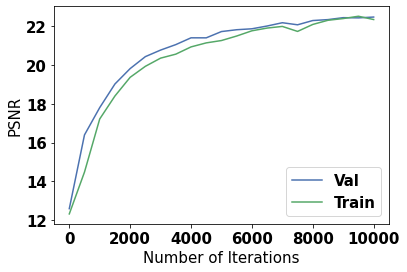

In [ ]:
plt.plot(epochs, meta_test_psnrs, label='Val')
plt.plot(epochs, meta_train_psnrs, label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Number of Iterations')
plt.show()

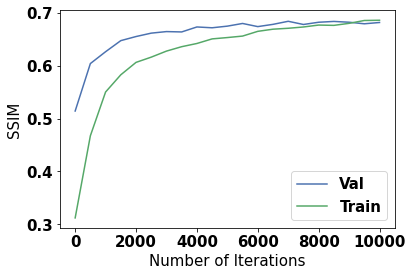

In [ ]:
plt.plot(epochs, meta_test_ssims, label='Val')
plt.plot(epochs, meta_train_ssims, label='Train')
plt.legend()
plt.ylabel('SSIM')
plt.xlabel('Number of Iterations')
plt.show()

## Evaluation

In [ ]:
if evaluation_mode:
  
  for i, img_name in enumerate(selected_images_test):

    # Bicubic and Ground Truth
    coords_base, target_base, meta_test_support_C, meta_test_support_H, meta_test_support_W, meta_test_query_C, meta_test_query_H, meta_test_query_W, coords_hr, target_hr, PSNR_bicubic_prediction, SSIM_bicubic_prediction, bicubic_prediction, ground_truth = \
    coords_base_list[i], target_base_list[i], meta_test_support_C_list[i], meta_test_support_H_list[i], meta_test_support_W_list[i], meta_test_query_C_list[i], meta_test_query_H_list[i], meta_test_query_W_list[i], coords_hr_list[i], target_hr_list[i], PSNR_bicubic_prediction_list[i], SSIM_bicubic_prediction_list[i], bicubic_prediction_list[i], ground_truth_list[i]

    # Meta-Learned
    model_predictions, model_best_step, best_PSNR_value, best_SSIM_value, steps = model.meta_test_with_ground_truth(
                                            coords_base, target_base,
                                            meta_test_support_H, meta_test_support_W, meta_test_support_C, meta_test_query_H, meta_test_query_W, meta_test_query_C,
                                            # update_step_test, meta_test_evaluation_steps, coords_hr, target_hr)
                                            3000, meta_test_evaluation_steps, coords_hr, target_hr)

    # Random
    model_predictions_random, model_best_step_random, best_PSNR_value_random, best_SSIM_value_random, steps_random = model_random.meta_test_with_ground_truth(
                                            coords_base, target_base,
                                            meta_test_support_H, meta_test_support_W, meta_test_support_C, meta_test_query_H, meta_test_query_W, meta_test_query_C,
                                            # update_step_test, meta_test_evaluation_steps, coords_hr, target_hr)
                                            3000, meta_test_evaluation_steps, coords_hr, target_hr)

    print("=====================================================================")
    print("Image {}".format(img_name))
    print("Bicubic: PSNR {}, SSIM {}".format(PSNR_bicubic_prediction, SSIM_bicubic_prediction))
    print("Meta Initialization: Best PSNR {}, Best PSNR Step {}, Best SSIM {}".format(best_PSNR_value, model_best_step, best_SSIM_value))
    print("Random Initialization: Best PSNR {}, Best PSNR Step {}, Best SSIM {}".format(best_PSNR_value_random, model_best_step_random, best_SSIM_value_random))

    plt.figure(figsize=(60,15))
    max_steps = len(steps)
    for j in range(max_steps):
      
      model_prediction = model_predictions[j].cpu().reshape(meta_test_query_H, meta_test_query_W, meta_test_query_C).permute(2,0,1)
      model_prediction_random = model_predictions_random[j].cpu().reshape(meta_test_query_H, meta_test_query_W, meta_test_query_C).permute(2,0,1)

      plt.subplot(2,max_steps+2,j+1)
      plt.imshow(np.clip(model_prediction,0,1).permute(1,2,0))
      plt.yticks([])
      plt.xticks([])
      if j == 0:
        plt.ylabel('Meta Initialization')
      plt.title(f'Step {steps[j]}')

      plt.subplot(2,max_steps+2,j+3+max_steps)
      plt.imshow(np.clip(model_prediction_random,0,1).permute(1,2,0))
      plt.yticks([])
      plt.xticks([])
      if j == 0:
          plt.ylabel('Random Initialization')
    plt.subplot(1,max_steps+2,max_steps+1)
    plt.imshow(bicubic_prediction.permute(1,2,0))
    plt.title('Bicubic Interpolation')
    plt.axis('off')
    plt.tight_layout() 
    plt.subplot(1,max_steps+2,max_steps+2)
    plt.imshow(ground_truth.permute(1,2,0))
    plt.title('Ground Truth (HR)')
    plt.axis('off')
    plt.tight_layout()  
    plt.show()

In [ ]:
# 10 update steps:

In [ ]:
if evaluation_mode:
  
  val_psnr_bicubic = []
  val_ssim_bicubic = []
  val_psnr = []
  val_ssim = []
  val_psnr_random = []
  val_ssim_random = []

  for img_test in img_name_list_test:

    coords_base, target_base, meta_test_support_C, meta_test_support_H, meta_test_support_W, meta_test_query_C, meta_test_query_H, meta_test_query_W, coords_hr, target_hr, PSNR_bicubic_prediction, SSIM_bicubic_prediction, bicubic_prediction, ground_truth = prepare_meta_test_image(
                              [img_test], task_count_test, support_set_size_test, query_set_size_test, img_name_list_test, dataset_name, 
                              img_name_list_test_start, img_name_list_test_end, img_type, downscaling_factor, downscaling_method,
                              patch_size_lr, patch_count, use_trimensional, use_sine_layer, coordinate_sys_option, fourier_feature_size, sigma, use_fourier,
                              phi, use_noise, coord_noise_factor, target_noise_factor)  
    
    val_psnr_bicubic.append(PSNR_bicubic_prediction)
    val_ssim_bicubic.append(SSIM_bicubic_prediction)

    # Meta-Learned
    model_predictions, model_best_step, best_PSNR_value, best_SSIM_value, steps = model.meta_test_with_ground_truth(
                                            coords_base, target_base,
                                            meta_test_support_H, meta_test_support_W, meta_test_support_C, meta_test_query_H, meta_test_query_W, meta_test_query_C,
                                            10, meta_test_evaluation_steps, coords_hr, target_hr)
    val_psnr.append(best_PSNR_value)
    val_ssim.append(best_SSIM_value)

    # Random
    model_predictions_random, model_best_step_random, best_PSNR_value_random, best_SSIM_value_random, steps_random = model_random.meta_test_with_ground_truth(
                                            coords_base, target_base,
                                            meta_test_support_H, meta_test_support_W, meta_test_support_C, meta_test_query_H, meta_test_query_W, meta_test_query_C,
                                            10, meta_test_evaluation_steps, coords_hr, target_hr)

    val_psnr_random.append(best_PSNR_value_random)
    val_ssim_random.append(best_SSIM_value_random)

In [ ]:
if evaluation_mode:
    
  if downscaling_factor != 1:
    result_df = pd.DataFrame(zip(val_psnr_bicubic, val_psnr_random, val_psnr, val_ssim_bicubic, val_ssim_random, val_ssim)
            , columns=['Bicubic PSNR', 'Random Initialization PSNR', 'Meta Initialization PSNR',
                      'Bicubic SSIM', 'Random Initialization SSIM', 'Meta Initialization SSIM'])
  else:
    result_df = pd.DataFrame(zip(val_psnr_random, val_psnr, val_ssim_random, val_ssim)
            , columns=['Random Initialization PSNR', 'Meta Initialization PSNR',
                      'Random Initialization SSIM', 'Meta Initialization SSIM'])
  result_df.describe()

In [ ]:
if evaluation_mode:
    
  result_df.to_csv("result_df_{}_{}.csv".format(version, dataset_name))
  files.download("result_df_{}_{}.csv".format(version, dataset_name))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
result_df.describe()

,Bicubic PSNR,Random Initialization PSNR,Meta Initialization PSNR,Bicubic SSIM,Random Initialization SSIM,Meta Initialization SSIM
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,24.127,13.214,21.592,0.725,0.454,0.624
std,1.992,1.587,1.523,0.066,0.088,0.062
min,18.261,9.171,16.336,0.409,0.171,0.346
25%,22.917,12.102,20.634,0.686,0.396,0.587
50%,24.080,12.968,21.660,0.729,0.449,0.629
75%,25.303,14.166,22.552,0.768,0.512,0.663
max,32.255,19.468,26.240,0.908,0.745,0.784


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


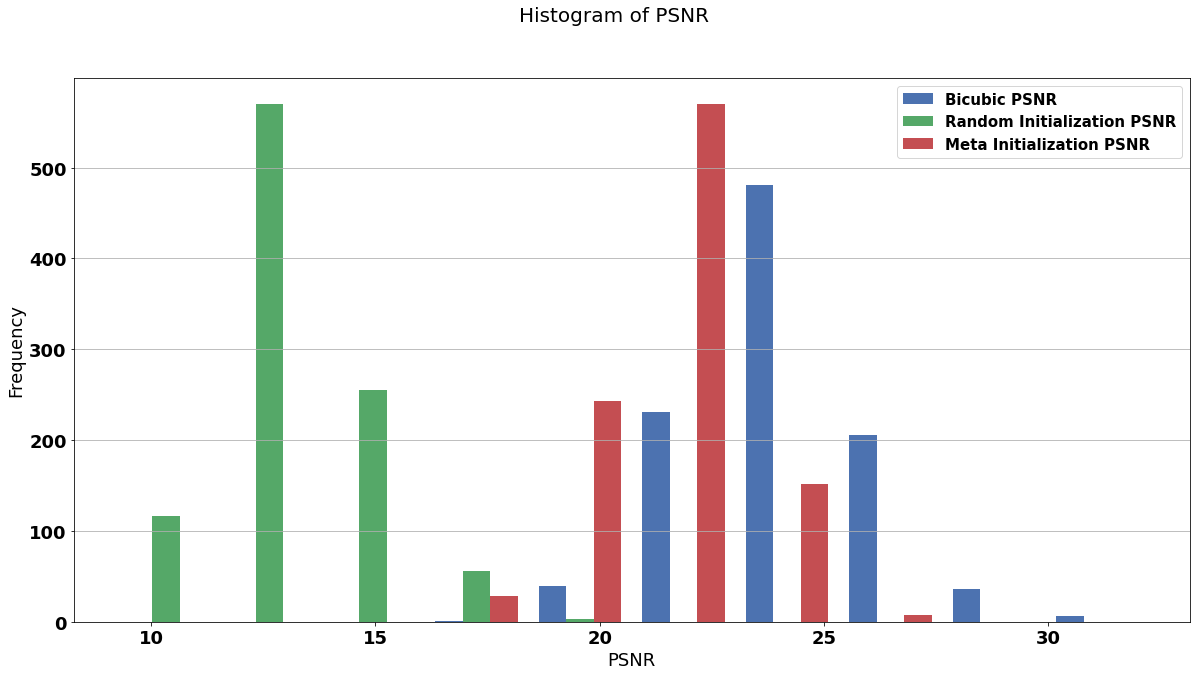

In [ ]:
if evaluation_mode:
  
  if downscaling_factor != 1:
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Histogram of PSNR', fontsize=20)
    plt.hist([np.array(val_psnr_bicubic), np.array(val_psnr_random), np.array(val_psnr)], 10, label=['Bicubic PSNR', 'Random Initialization PSNR', 'Meta Initialization PSNR'])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xlabel('PSNR', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()
  else:
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Histogram of PSNR', fontsize=20)
    plt.hist([np.array(val_psnr_random), np.array(val_psnr)], 10, label=['Random Initialization PSNR', 'Meta Initialization PSNR'])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xlabel('PSNR', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()

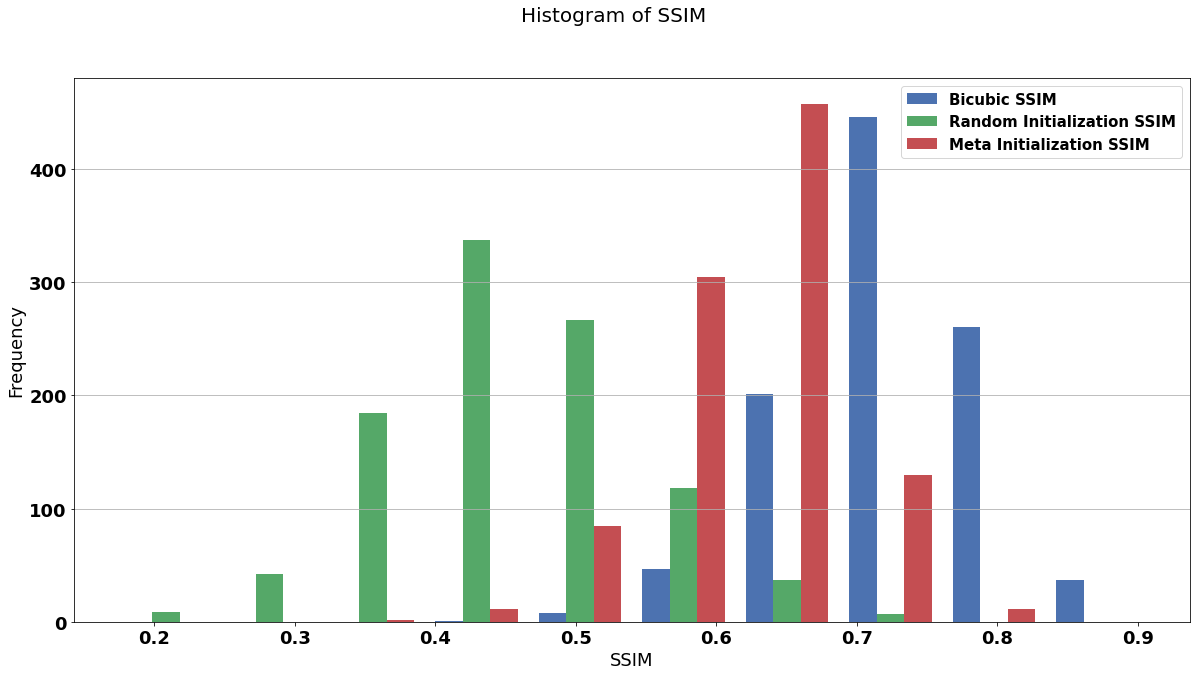

In [ ]:
if evaluation_mode:

  if downscaling_factor != 1:    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Histogram of SSIM', fontsize=20)
    plt.hist([np.array(val_ssim_bicubic), np.array(val_ssim_random), np.array(val_ssim)], 10, label=['Bicubic SSIM', 'Random Initialization SSIM', 'Meta Initialization SSIM'])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xlabel('SSIM', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()
  else:    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Histogram of SSIM', fontsize=20)
    plt.hist([np.array(val_ssim_random), np.array(val_ssim)], 10, label=['Random Initialization SSIM', 'Meta Initialization SSIM'])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xlabel('SSIM', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()

No handles with labels found to put in legend.


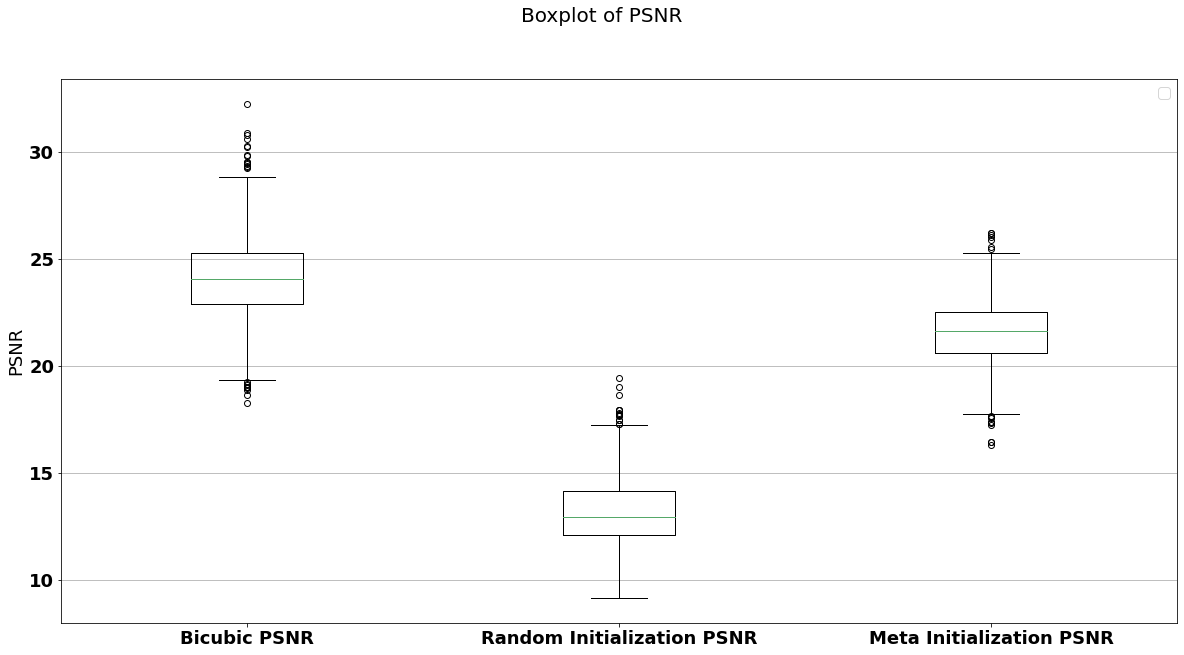

In [ ]:
if evaluation_mode:
  
  if downscaling_factor != 1: 
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Boxplot of PSNR', fontsize=20)
    plt.boxplot([np.array(val_psnr_bicubic), np.array(val_psnr_random), np.array(val_psnr)])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xticks([1, 2, 3], ['Bicubic PSNR', 'Random Initialization PSNR', 'Meta Initialization PSNR'])
    plt.ylabel('PSNR', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()
  else: 
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Boxplot of PSNR', fontsize=20)
    plt.boxplot([np.array(val_psnr_random), np.array(val_psnr)])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xticks([1, 2], ['Random Initialization PSNR', 'Meta Initialization PSNR'])
    plt.ylabel('PSNR', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()

No handles with labels found to put in legend.


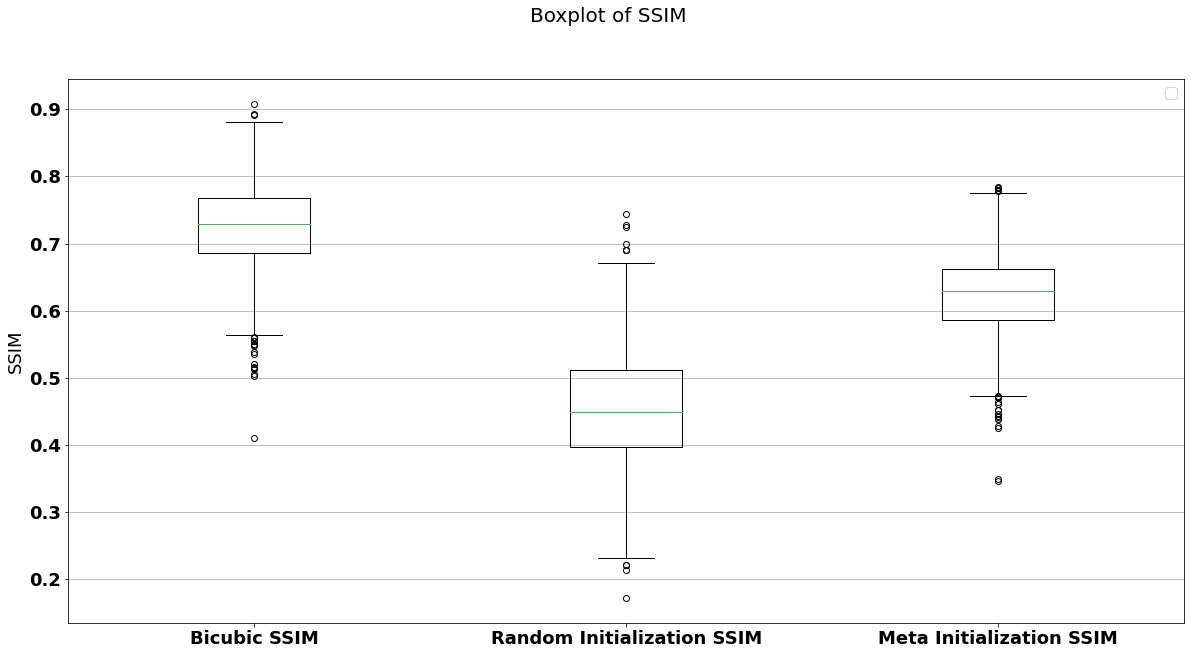

In [ ]:
if evaluation_mode:
  
  if downscaling_factor != 1: 
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Boxplot of SSIM', fontsize=20)
    plt.boxplot([np.array(val_ssim_bicubic), np.array(val_ssim_random), np.array(val_ssim)])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xticks([1, 2, 3], ['Bicubic SSIM', 'Random Initialization SSIM', 'Meta Initialization SSIM'])
    plt.ylabel('SSIM', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()
  else: 
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Boxplot of SSIM', fontsize=20)
    plt.boxplot([np.array(val_ssim_random), np.array(val_ssim)])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xticks([1, 2], ['Random Initialization SSIM', 'Meta Initialization SSIM'])
    plt.ylabel('SSIM', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()

In [ ]:
# 100 update steps:

In [ ]:
if evaluation_mode:
  
  val_psnr_bicubic = []
  val_ssim_bicubic = []
  val_psnr = []
  val_ssim = []
  val_psnr_random = []
  val_ssim_random = []

  for img_test in img_name_list_test:

    coords_base, target_base, meta_test_support_C, meta_test_support_H, meta_test_support_W, meta_test_query_C, meta_test_query_H, meta_test_query_W, coords_hr, target_hr, PSNR_bicubic_prediction, SSIM_bicubic_prediction, bicubic_prediction, ground_truth = prepare_meta_test_image(
                              [img_test], task_count_test, support_set_size_test, query_set_size_test, img_name_list_test, dataset_name, 
                              img_name_list_test_start, img_name_list_test_end, img_type, downscaling_factor, downscaling_method,
                              patch_size_lr, patch_count, use_trimensional, use_sine_layer, coordinate_sys_option, fourier_feature_size, sigma, use_fourier,
                              phi, use_noise, coord_noise_factor, target_noise_factor)  
    
    val_psnr_bicubic.append(PSNR_bicubic_prediction)
    val_ssim_bicubic.append(SSIM_bicubic_prediction)

    # Meta-Learned
    model_predictions, model_best_step, best_PSNR_value, best_SSIM_value, steps = model.meta_test_with_ground_truth(
                                            coords_base, target_base,
                                            meta_test_support_H, meta_test_support_W, meta_test_support_C, meta_test_query_H, meta_test_query_W, meta_test_query_C,
                                            100, meta_test_evaluation_steps, coords_hr, target_hr)
    val_psnr.append(best_PSNR_value)
    val_ssim.append(best_SSIM_value)

    # Random
    model_predictions_random, model_best_step_random, best_PSNR_value_random, best_SSIM_value_random, steps_random = model_random.meta_test_with_ground_truth(
                                            coords_base, target_base,
                                            meta_test_support_H, meta_test_support_W, meta_test_support_C, meta_test_query_H, meta_test_query_W, meta_test_query_C,
                                            100, meta_test_evaluation_steps, coords_hr, target_hr)

    val_psnr_random.append(best_PSNR_value_random)
    val_ssim_random.append(best_SSIM_value_random)

In [ ]:
if evaluation_mode:
    
  if downscaling_factor != 1:
    result_df = pd.DataFrame(zip(val_psnr_bicubic, val_psnr_random, val_psnr, val_ssim_bicubic, val_ssim_random, val_ssim)
            , columns=['Bicubic PSNR', 'Random Initialization PSNR', 'Meta Initialization PSNR',
                      'Bicubic SSIM', 'Random Initialization SSIM', 'Meta Initialization SSIM'])
  else:
    result_df = pd.DataFrame(zip(val_psnr_random, val_psnr, val_ssim_random, val_ssim)
            , columns=['Random Initialization PSNR', 'Meta Initialization PSNR',
                      'Random Initialization SSIM', 'Meta Initialization SSIM'])
  result_df.describe()

In [ ]:
result_df.describe()

,Bicubic PSNR,Random Initialization PSNR,Meta Initialization PSNR,Bicubic SSIM,Random Initialization SSIM,Meta Initialization SSIM
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,24.127,18.820,23.669,0.725,0.610,0.703
std,1.992,2.092,1.943,0.066,0.086,0.066
min,18.261,14.197,17.618,0.409,0.272,0.402
25%,22.917,17.291,22.467,0.686,0.556,0.665
50%,24.080,18.511,23.648,0.729,0.611,0.708
75%,25.303,19.888,24.813,0.768,0.668,0.745
max,32.255,27.902,31.121,0.908,0.849,0.883


In [ ]:
if evaluation_mode:
    
  result_df.to_csv("result_df_{}_{}.csv".format(version, dataset_name))
  files.download("result_df_{}_{}.csv".format(version, dataset_name))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

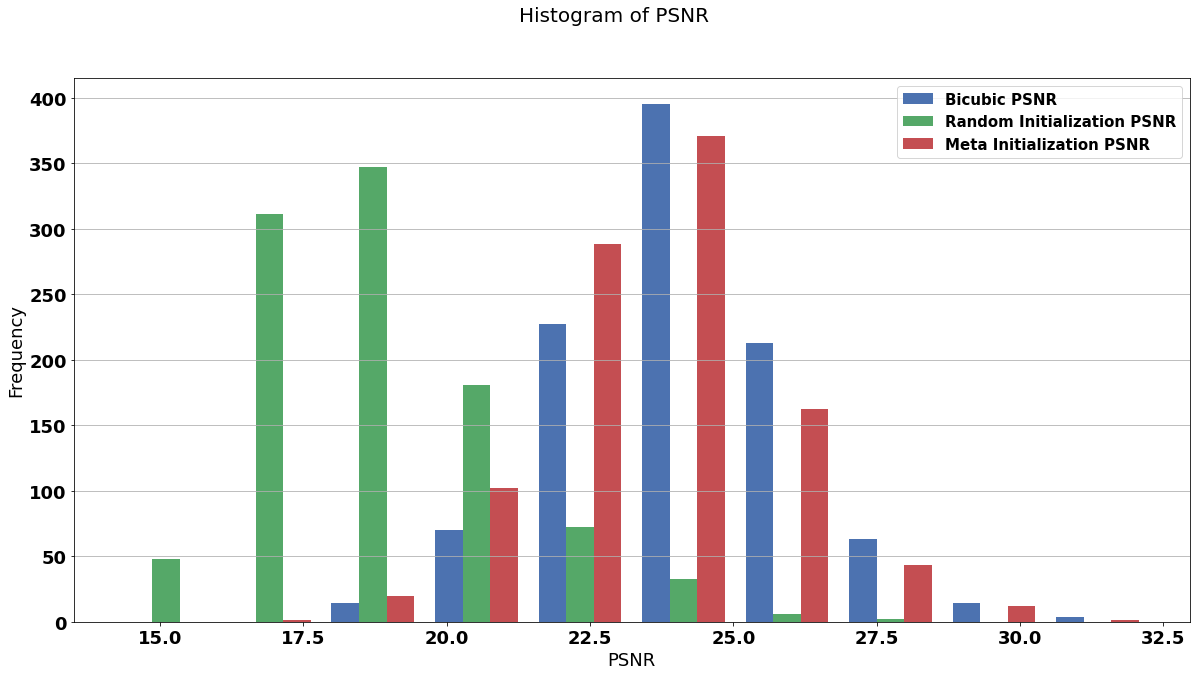

In [ ]:
if evaluation_mode:
  
  if downscaling_factor != 1:
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Histogram of PSNR', fontsize=20)
    plt.hist([np.array(val_psnr_bicubic), np.array(val_psnr_random), np.array(val_psnr)], 10, label=['Bicubic PSNR', 'Random Initialization PSNR', 'Meta Initialization PSNR'])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xlabel('PSNR', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()
  else:
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Histogram of PSNR', fontsize=20)
    plt.hist([np.array(val_psnr_random), np.array(val_psnr)], 10, label=['Random Initialization PSNR', 'Meta Initialization PSNR'])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xlabel('PSNR', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()

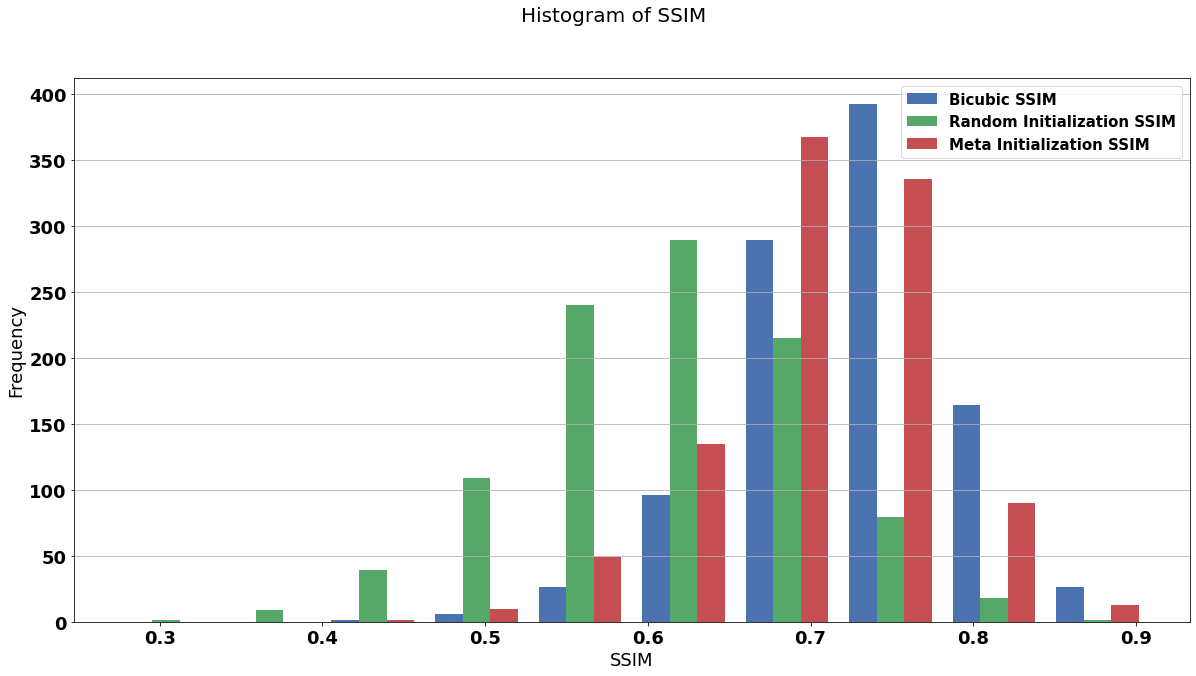

In [ ]:
if evaluation_mode:

  if downscaling_factor != 1:    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Histogram of SSIM', fontsize=20)
    plt.hist([np.array(val_ssim_bicubic), np.array(val_ssim_random), np.array(val_ssim)], 10, label=['Bicubic SSIM', 'Random Initialization SSIM', 'Meta Initialization SSIM'])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xlabel('SSIM', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()
  else:    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Histogram of SSIM', fontsize=20)
    plt.hist([np.array(val_ssim_random), np.array(val_ssim)], 10, label=['Random Initialization SSIM', 'Meta Initialization SSIM'])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xlabel('SSIM', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()

No handles with labels found to put in legend.


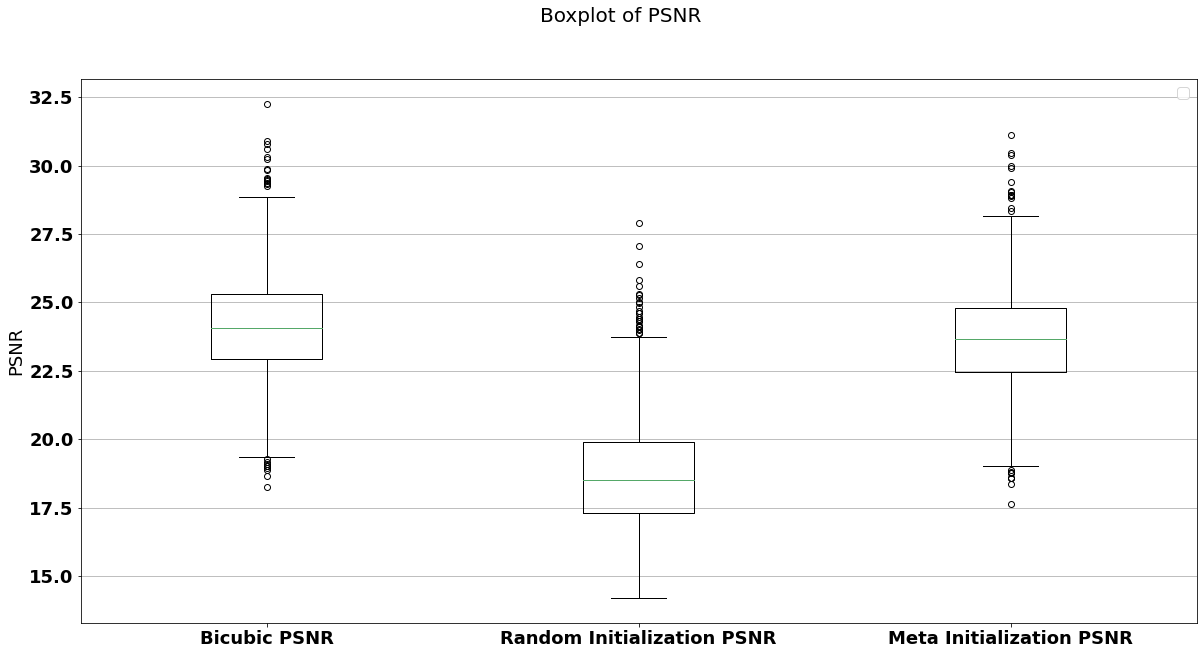

In [ ]:
if evaluation_mode:
  
  if downscaling_factor != 1: 
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Boxplot of PSNR', fontsize=20)
    plt.boxplot([np.array(val_psnr_bicubic), np.array(val_psnr_random), np.array(val_psnr)])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xticks([1, 2, 3], ['Bicubic PSNR', 'Random Initialization PSNR', 'Meta Initialization PSNR'])
    plt.ylabel('PSNR', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()
  else: 
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Boxplot of PSNR', fontsize=20)
    plt.boxplot([np.array(val_psnr_random), np.array(val_psnr)])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xticks([1, 2], ['Random Initialization PSNR', 'Meta Initialization PSNR'])
    plt.ylabel('PSNR', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()

No handles with labels found to put in legend.


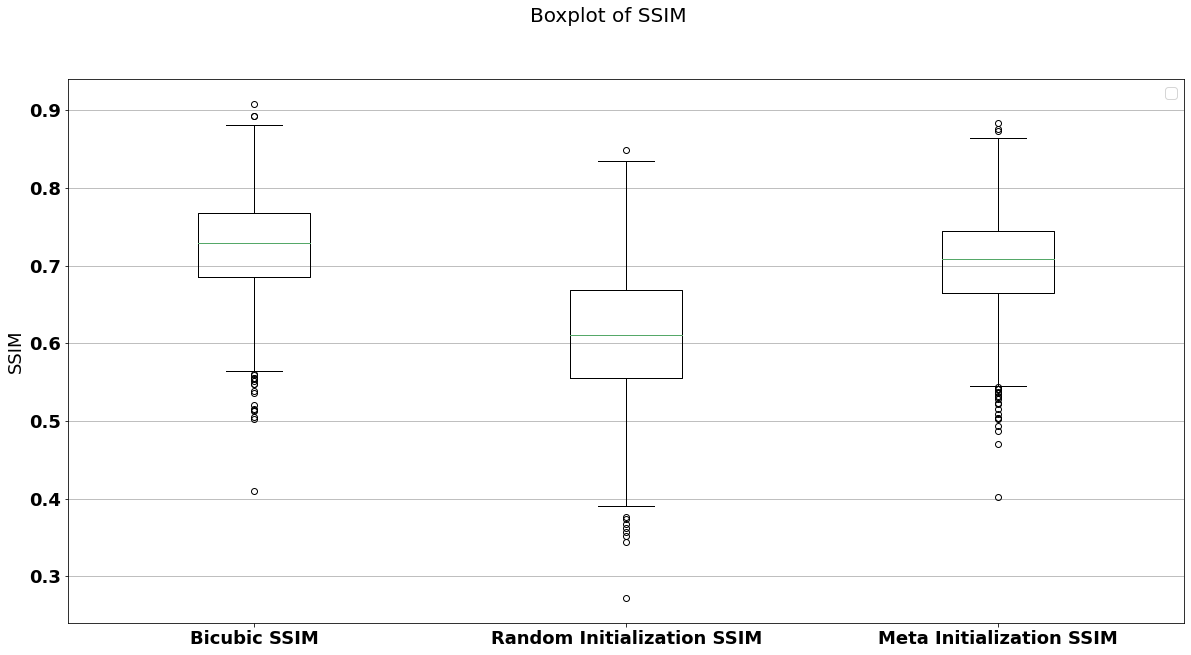

In [ ]:
if evaluation_mode:
  
  if downscaling_factor != 1: 
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Boxplot of SSIM', fontsize=20)
    plt.boxplot([np.array(val_ssim_bicubic), np.array(val_ssim_random), np.array(val_ssim)])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xticks([1, 2, 3], ['Bicubic SSIM', 'Random Initialization SSIM', 'Meta Initialization SSIM'])
    plt.ylabel('SSIM', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()
  else: 
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Boxplot of SSIM', fontsize=20)
    plt.boxplot([np.array(val_ssim_random), np.array(val_ssim)])
    plt.legend(loc='upper right', prop={'size': 15})
    plt.xticks([1, 2], ['Random Initialization SSIM', 'Meta Initialization SSIM'])
    plt.ylabel('SSIM', fontsize=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.grid(axis = 'y')
    plt.show()

## Save as PDF

In [ ]:
%cd /content/gdrive/MyDrive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project/Finalized Codes/COMASure/

/content/gdrive/MyDrive/MSc DSML/UCL/Main/COMP0158 MSc DSML Project


In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-recommended

In [ ]:
# Remember to rename the pdf to include dataset_name, downscaling_factor, downscaling_method, img_name_list, and version

!!jupyter nbconvert --to pdf "$filename_for_download_as_pdf"

['[NbConvertApp] Converting notebook v10.2.1_Coordinate_Network.ipynb to pdf',
 '[NbConvertApp] Support files will be in v10.2.1_Coordinate_Network_files/',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Making directory ./v10.2.1_Coordinate_Network_files',
 '[NbConvertApp] Writing 192915 bytes to ./notebook.tex',
 '[NbConvertApp] Building PDF',
 "[NbConvertApp] Running xelatex 3 times: [